In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import sklearn.metrics as metrics
import scipy as sp
%matplotlib inline
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.cluster import DBSCAN
import random
from kmodes.kmodes import KModes

In [2]:
# IMPORT DATA

df = pd.read_json('yelp_dataset/yelp_academic_dataset_business.json', lines=True)
print(df)


                   business_id                     name               address  \
0       6iYb2HFDywm3zjuRg0shjw      Oskar Blues Taproom          921 Pearl St   
1       tCbdrRPZA0oiIYSmHG3J0w  Flying Elephants at PDX   7000 NE Airport Way   
2       bvN78flM8NLprQ1a1y5dRg           The Reclaimory    4720 Hawthorne Ave   
3       oaepsyvc0J17qwi8cfrOWg              Great Clips    2566 Enterprise Rd   
4       PE9uqAjdw0E4-8mjGl3wVA        Crossfit Terminus   1046 Memorial Dr SE   
...                        ...                      ...                   ...   
160580  D2mHoIDXx9N8mS1pGoKV9Q       Eleven Oaks Realty                         
160581  bQX-kwVTyZgcdZGEPzce6Q             Webb's Honey    21777 State Rd 520   
160582  wvFZ06nmPmQ2-IVoPqVYLA    Painting with a Twist  2164 S Chickasaw Trl   
160583  GB75wPibj3IjNauaoCxyGA              Havana Cafe        910 NW 14th St   
160584  ngmLL5Y5OT-bYHKU0kKrYA              Zora Grille   1370 E Altamonte Dr   

                     city s

In [369]:
# CLEAN DATA

n = 10
print(df['state'].value_counts()[:n].index.tolist())


df_filtered = df[(df['state']=='MA')]
df_cluster = df_filtered.filter(items=['business_id','latitude','longitude','categories', 'review_count', 'stars'])
df_filtered = df_filtered.filter(items=['business_id','name','address','city','state','stars','review_count','is_open','attributes','categories'])

print(df_filtered)
print(df_filtered.shape[0])




['MA', 'OR', 'TX', 'FL', 'GA', 'BC', 'OH', 'CO', 'WA', 'CA']
                   business_id                                 name  \
11      hCABMnKtwo4Y9alQDxh2kw         Star Kreations Salon and Spa   
12      HPA_qyMEddpAEtFof02ixg                  Mr G's Pizza & Subs   
18      6fT0lYr_UgWSCZs_w1PBTQ                        Salter School   
26      hcRxdDg7DYryCxCoI8ySQA                    Longwood Galleria   
29      jGennaZUr2MsJyRhijNBfA                      Legal Sea Foods   
...                        ...                                  ...   
160556  87f7kR7nTz8WHnmtLM_S6w                                 O Ya   
160563  yQL8SrSETbbCI1U5esVJQw                  Ciao! Pizza & Pasta   
160568  hX-wc8LoHWSWjBwZ84ANcg          Chestnut Green Dental Group   
160569  _-nynGfhsMVVWWbAZ6YhTw                        The Jury Room   
160579  d6iEdtgLKelWKtb-2UmE2A  Master Finish Mobile Auto Detailing   

                       address     city state  stars  review_count  is_open  \
11     

## Cluster based on location

In [40]:
df_cluster

,business_id,latitude,longitude,categories,review_count,stars
11,hCABMnKtwo4Y9alQDxh2kw,42.534248,-70.990948,"Wigs, Hair Extensions, Hair Salons, Blow Dry/O...",8,4.0
12,HPA_qyMEddpAEtFof02ixg,42.541155,-70.973438,"Food, Pizza, Restaurants",39,4.0
18,6fT0lYr_UgWSCZs_w1PBTQ,42.427889,-71.073475,"Specialty Schools, Massage Schools, Middle Sch...",5,2.0
26,hcRxdDg7DYryCxCoI8ySQA,42.338544,-71.106842,"Restaurants, Shopping, Shopping Centers",24,2.5
29,jGennaZUr2MsJyRhijNBfA,42.363442,-71.025781,"Sandwiches, Food, Restaurants, Breakfast & Bru...",856,3.5
...,...,...,...,...,...,...
160556,87f7kR7nTz8WHnmtLM_S6w,42.351408,-71.056867,"Japanese, Sushi Bars, Restaurants",737,4.5
160563,yQL8SrSETbbCI1U5esVJQw,42.389221,-71.040882,"Restaurants, Pizza, Italian",733,5.0
160568,hX-wc8LoHWSWjBwZ84ANcg,42.550054,-70.944788,"Health & Medical, Dentists, General Dentistry",6,3.0
160569,_-nynGfhsMVVWWbAZ6YhTw,42.249118,-71.001071,"Restaurants, American (New), Nightlife",30,3.0


In [41]:
df_location = df_cluster.filter(items= ['latitude','longitude'])
df_location

,latitude,longitude
11,42.534248,-70.990948
12,42.541155,-70.973438
18,42.427889,-71.073475
26,42.338544,-71.106842
29,42.363442,-71.025781
...,...,...
160556,42.351408,-71.056867
160563,42.389221,-71.040882
160568,42.550054,-70.944788
160569,42.249118,-71.001071


In [59]:
db = DBSCAN(eps=0.00005, min_samples=3, algorithm='ball_tree', metric='haversine').fit(np.radians(df_location))

In [60]:
labels = db.labels_

In [61]:
labels

array([ 0,  1,  2, ..., 19,  6, -1])

In [62]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

In [63]:
-1 in labels

True

In [64]:
df_location.iloc(0)[2]['latitude']

42.427889

In [65]:
len(colors)

444

In [66]:
labels[1]
random.shuffle(colors)

Plotting for location clusters

/var/folders/22/yn6463hn3gl4tmn8ckzyxcb40000gn/T/ipykernel_3880/4157913855.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x,y,'ro',color=c, markeredgecolor = 'k')


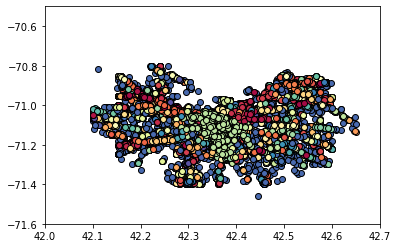

In [67]:
plt.xlim(42,42.7)
plt.ylim(-71.6,-70.5)
for i in range(0,len(labels)):
    if(labels[i] == -1):
       c = [0,0,0,1]
    c = colors[labels[i]]
    x = df_location.iloc(0)[i]['latitude']
    y = df_location.iloc(0)[i]['longitude']
    plt.plot(x,y,'ro',color=c, markeredgecolor = 'k')

Generate list of dataframe, each containing a cluster

In [68]:
cluster_list = [None] * len(set(labels))
for i in range(0,len(labels)):
    index = labels[i]
    if index != -1:
        if cluster_list[index] == None:
            cluster_list[index] = []
            cluster_list[index].append(df_cluster.iloc(0)[i])
        else:
            cluster_list[index].append(df_cluster.iloc(0)[i])

In [69]:
for i in range(0, len(cluster_list)):
    df_new = pd.DataFrame(cluster_list[i])
    cluster_list[i] = df_new

In [70]:
t = np.array(cluster_list[0]['categories']).tolist()

In [71]:
for i in range(0,len(t)):
    text = t[i]
    t[i] = [x.strip() for x in text.split(',')]


In [72]:
unique_categories = list(set(i for j in t for i in j))
df_test = pd.DataFrame(index = range(0,len(t)), columns = unique_categories)

In [73]:
for i in range(0,len(t)):
    for each in t[i]:
        df_test.loc[i,each] = each
df_test.loc[0,'Wigs']
df_test.isnull().values.any()
df_test
df_test.shape

(135, 223)

In [74]:
while(df_test.isnull().values.any()==True):
    df_test.fillna(str(random.random() * 10000),inplace=True,limit=1)

In [75]:
km = KModes(n_clusters=50, init='Huang', n_init=5, verbose=1)
clusters = km.fit_predict(df_test)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1, cost: 18714.0
Run 1, iteration: 2/100, moves: 0, cost: 18714.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 2, cost: 18722.0
Run 2, iteration: 2/100, moves: 0, cost: 18722.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 18725.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 18719.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 18728.0
Best run was number 1


In [76]:
l = [None] * len(set(clusters))
for i in range(0,len(clusters)):
    index = clusters[i]
    if index != -1:
        if l[index] == None:
            l[index] = []
            l[index].append(cluster_list[0].iloc(0)[i])
        else:
            l[index].append(cluster_list[0].iloc(0)[i])


## Clustering for each location cluster

The result is expected to be a list, with each element as a list of clusters. 

In [77]:
res = []
for i in range(0,len(cluster_list)):
    t = np.array(cluster_list[i]['categories']).tolist()
    for j in range(0,len(t)):
        text = t[j]
        if(text == None):
            text = 'None'
        t[j] = [x.strip() for x in text.split(',')]
    unique_categories = list(set(k for j in t for k in j))
    df_test = pd.DataFrame(index = range(0,len(t)), columns = unique_categories)
    for j in range(0,len(t)):
        for each in t[j]:
            df_test.loc[j,each] = each
    while(df_test.isnull().values.any()==True):
        df_test.fillna(str(random.random() * 10000),inplace=True,limit=1)
    km = KModes(n_clusters=int(min(df_test.shape[0]/3,50)), init='Huang', n_init=5, verbose=1)
    clusters = km.fit_predict(df_test)
    l = [None] * len(set(clusters))
    for j in range(0,len(clusters)):
        index = clusters[j]
        if index != -1:
            if l[index] == None:
                l[index] = []
                l[index].append(cluster_list[i].iloc(0)[j])
            else:
                l[index].append(cluster_list[i].iloc(0)[j])
    res.append(l)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 19839.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 19830.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 2, cost: 19818.0
Run 3, iteration: 2/100, moves: 0, cost: 19818.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 1, cost: 19811.0
Run 4, iteration: 2/100, moves: 0, cost: 19811.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 1, cost: 19827.0
Run 5, iteration: 2/100, moves: 0, cost: 19827.0
Best run was number 4
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 247.0
Init: initializing centroids
Init: initializing clusters
St

KeyboardInterrupt: 

In [86]:
cluster_list[2]

2

# Assigning Labels

In [370]:
# Example data for testing
clustered_df = pd.DataFrame(res[0][0])
clustered_df

,business_id,latitude,longitude,categories,review_count,stars
23580,fe20B7ThaCVHDhrIvWY2hw,42.522331,-70.996643,"Restaurants, Greek, Mediterranean",222,4.0
34541,ANwm3ELINhJzKvcUTYTMKQ,42.536378,-70.989787,"Restaurants, Vietnamese",189,4.0
44375,x52z54yr5tU1dDrL7lBoOw,42.547787,-70.980655,"Arts & Entertainment, Active Life, Festivals, ...",21,4.5
45241,IoATdImB26te-zWf8L_8-g,42.546429,-70.984252,"Active Life, Amusement Parks",8,3.5
63156,5yv4RdbeVXKZR3Y9i8LJTw,42.546830,-70.980516,"Arcades, Event Planning & Services, Venues & E...",52,3.5
75622,WC0Ug1Tv6AuF5esCmCJFyQ,42.544974,-70.979724,"Magicians, Bookstores, Shopping, Hobby Shops, ...",7,4.0


In [346]:
# Average review count for (cluster) the category in that location
avg_review = clustered_df["review_count"].mean()

print("Average Review Count for this category:", avg_review, "\n")

print("Get all stars:\n",clustered_df['stars'], "\n")
print("Get all Review counts:\n",clustered_df['review_count'], "\n")


print("Stars for a specific location: ", clustered_df.iloc(0)[0]['stars'])
print("Review count for a specific location: ", clustered_df.iloc(0)[0]['review_count'])

#cat_df = clustered_df[clustered_df['categories'].str.contains('Nail.*')==True]


Average Review Count for this category: 83.16666666666667 

Get all stars:
 23580    4.0
34541    4.0
44375    4.5
45241    3.5
63156    3.5
75622    4.0
Name: stars, dtype: float64 

Get all Review counts:
 23580    222
34541    189
44375     21
45241      8
63156     52
75622      7
Name: review_count, dtype: int64 

Stars for a specific location:  4.0
Review count for a specific location:  222


In [387]:
# Checking if successful/unsuccessfull
## First check if stars > 4
### Then checks if review count if > average count in that cluster
def successClassify(avg_review, review_count, stars):
    classify = ""
    if(stars >= 4):
        if(review_count >= avg_review):
            classify = "Successful"
            #print("Successful")
        else:
            classify = "NOT Successful"
            #print("Not Successful, (Review count is low: ", review_count, "Should be above average of: ", avg_review)
    else:
        classify = "NOT Successful"
        #print("Not successful, (stars lower than 4)")
        
    return classify

In [392]:
for i in range(0,len(res)):
    print( '\033[1m' + "Location Cluster: ", i + 1, '\033[0m' + "\n")
    for j in range(0, len(res[i])):
        print( "Category Cluster: ", j + 1, "\n")
        
        category_df = pd.DataFrame(res[i][j])
        avg_review = category_df["review_count"].mean()
        print("Average Review Count for this category cluster:", avg_review, "\n")
        for business in range(0,len(category_df)):            
            stars = category_df.iloc(0)[business]['stars']
            review_count = category_df.iloc(0)[business]['review_count']
            
            classify = successClassify(avg_review, review_count, stars)
                 
            print("Business:", business +1, "\tStars: ", stars, "\tReviews: ", review_count, "\tClassification: ", classify )
            print()
            
        print("-------------------------------------------------------------------------------\n")
    print("===============================================================================\n")
    

Location Cluster:  1 

Category Cluster:  1 

Average Review Count for this category cluster: 83.16666666666667 

Business: 1 	Stars:  4.0 	Reviews:  222 	Classification:  Successful

Business: 2 	Stars:  4.0 	Reviews:  189 	Classification:  Successful

Business: 3 	Stars:  4.5 	Reviews:  21 	Classification:  NOT Successful

Business: 4 	Stars:  3.5 	Reviews:  8 	Classification:  NOT Successful

Business: 5 	Stars:  3.5 	Reviews:  52 	Classification:  NOT Successful

Business: 6 	Stars:  4.0 	Reviews:  7 	Classification:  NOT Successful

-------------------------------------------------------------------------------

Category Cluster:  2 

Average Review Count for this category cluster: 14.090909090909092 

Business: 1 	Stars:  4.0 	Reviews:  14 	Classification:  NOT Successful

Business: 2 	Stars:  4.5 	Reviews:  16 	Classification:  Successful

Business: 3 	Stars:  4.5 	Reviews:  12 	Classification:  NOT Successful

Business: 4 	Stars:  5.0 	Reviews:  5 	Classification:  NOT Successf

Business: 1 	Stars:  3.5 	Reviews:  74 	Classification:  NOT Successful

Business: 2 	Stars:  3.0 	Reviews:  86 	Classification:  NOT Successful

-------------------------------------------------------------------------------

Category Cluster:  28 

Average Review Count for this category cluster: 26.5 

Business: 1 	Stars:  1.5 	Reviews:  23 	Classification:  NOT Successful

Business: 2 	Stars:  3.5 	Reviews:  9 	Classification:  NOT Successful

Business: 3 	Stars:  4.5 	Reviews:  9 	Classification:  NOT Successful

Business: 4 	Stars:  3.5 	Reviews:  21 	Classification:  NOT Successful

Business: 5 	Stars:  3.5 	Reviews:  13 	Classification:  NOT Successful

Business: 6 	Stars:  3.0 	Reviews:  84 	Classification:  NOT Successful

-------------------------------------------------------------------------------

Category Cluster:  29 

Average Review Count for this category cluster: 74.0 

Business: 1 	Stars:  3.0 	Reviews:  74 	Classification:  NOT Successful

-------------------------